# Calculating E2SFCA using Travel-Cost Matrices and Pysal Access


This notebook walks through calculating E2SFCA access with Travel-Cost Matrices generated by SPACTS and the [Pysal Access](https://access.readthedocs.io/) package.

In [ ]:
import access
import contextily as cx
import geopandas as gpd
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
from scipy.stats import pearsonr

/data/keeling/a/michels9/anaconda3/envs/tcm/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/cigi/scratch/michels9/tmp/ipykernel_31211/2185096208.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should b

In [ ]:
crs = "EPSG:3857"
figsize=(16, 7)
result_dir = "../data/access_results"

**Population Data**

First, we will load, clean, and plot the population data:

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,NAMELSAD,LSAD,ALAND,AWATER,pop,geometry
23,18,155,965700,1,1500000US181559657001,181559657001,1,Block Group 1,BG,77047964,4026807,1436.0,POINT (-9445165.374 4699077.562)
43,18,029,080601,1,1500000US180290806011,180290806011,1,Block Group 1,BG,33624572,12232,754.0,POINT (-9462818.728 4725547.314)
88,18,155,965800,1,1500000US181559658001,181559658001,1,Block Group 1,BG,78549791,112109,1083.0,POINT (-9477757.627 4705750.253)
283,18,137,968600,4,1500000US181379686004,181379686004,4,Block Group 4,BG,15716868,176750,926.0,POINT (-9493443.131 4738348.018)
304,18,115,965700,2,1500000US181159657002,181159657002,2,Block Group 2,BG,4693956,0,970.0,POINT (-9446906.479 4717496.550)


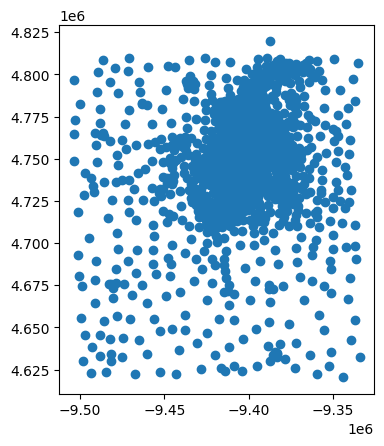

In [ ]:
pop = gpd.read_file("../data/pop_data/block_group/blockgroups.shp")
pop = pop.cx[-85.31237341:-83.90945057, 38.34659188:39.58974253]
pop = pop.to_crs(crs)
pop.geometry = pop.geometry.centroid
pop.plot()
pop.head()

,GEOID,pop,geometry
23,181559657001,1436.0,"POLYGON ((-9452364.248 4699670.024, -9452185.0..."
43,180290806011,754.0,"POLYGON ((-9467166.841 4724498.747, -9467157.2..."
88,181559658001,1083.0,"POLYGON ((-9484772.912 4709332.118, -9484737.6..."
283,181379686004,926.0,"POLYGON ((-9497442.584 4736558.444, -9497293.8..."
304,181159657002,970.0,"POLYGON ((-9449366.163 4719337.684, -9448996.9..."


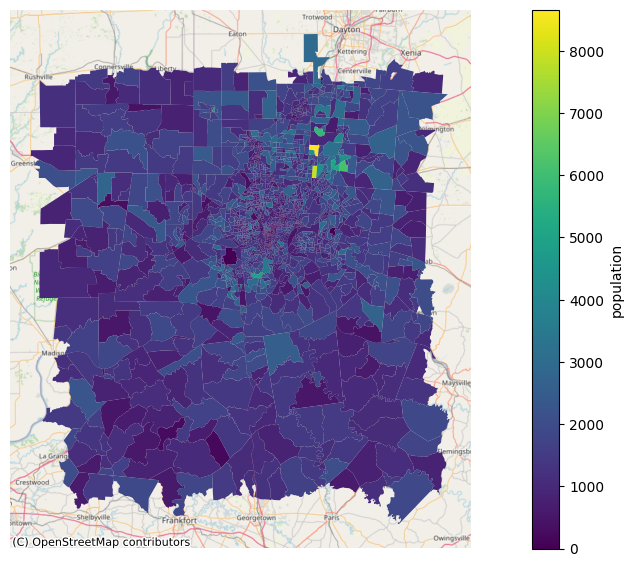

In [ ]:
pop_id, pop_data = "GEOID", "pop"
pop = gpd.read_file("../data/pop_data/block_group/blockgroups.shp")
pop = pop.cx[-85.31237341:-83.90945057, 38.34659188:39.58974253]
pop = pop[[pop_id, pop_data, "geometry"]]
pop[pop_id] = pop[pop_id].astype(str)
pop = pop.to_crs(crs)
ax = pop.plot(column=pop_data, figsize=figsize, legend=True, legend_kwds={"label": "population"})
ax.axis("off")
cx.add_basemap(ax, crs=pop.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
pop.head()

**Hospital Data**

Next, we load, clean, and plot the hospital data:

There are 54 hospitals.


,ID,BEDS,geometry
2106,0001947025,16,POINT (-9449080.453 4737411.488)
2170,0009047006,25,POINT (-9486928.220 4765458.431)
2223,0002247025,64,POINT (-9449176.759 4737668.704)
2528,0000941008,25,POINT (-9480945.900 4675981.963)
2538,0003241031,61,POINT (-9381749.142 4633810.623)


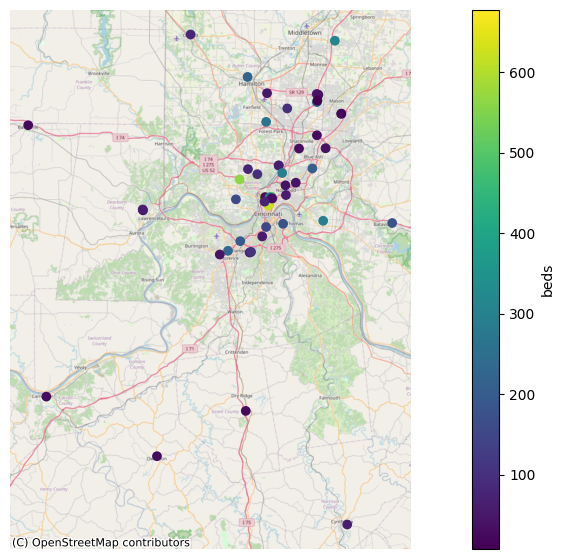

In [ ]:
# load the resources
hos = gpd.read_file("../data/geodata/resources/Hospitals.geojson")
# filter out negative beds since that's not possible
hos = hos[hos["BEDS"] >= 0]
hos = hos[["ID", "BEDS", "geometry"]]
# filter to out bounding box
hos = hos.cx[-85.31237341:-83.90945057, 38.34659188:39.58974253]
hos = hos.to_crs(crs)
ax = hos.plot(column="BEDS", figsize=figsize, legend=True, legend_kwds={"label": "beds"})
ax.axis("off")
cx.add_basemap(ax, crs=pop.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
print(f"There are {len(hos)} hospitals.")
hos.head()

In [ ]:
def time2nearest(demand, dindex, supply, sindex, tcm, origin, destination, cost):
    """
    Calculates the time to the nearest resource.
    """
    valid_paths = tcm[tcm[destination].isin(supply[sindex])]  # keep only the destinations ending in supply
    merged = demand[[dindex]].merge(valid_paths, left_on=dindex, right_on=origin)
    return merged.loc[merged.groupby(dindex)[cost].idxmin()].set_index(dindex)[[cost]]

<hr />

## Accessibility Using OSM

**Travel-Cost Matrices**

We calculated the Travel-Cost Matrix using OSM data.

In [ ]:
# tcm_ct2ct_osm = pd.read_csv("../data/tcm/TCM-128k-CT.csv")
tcm_ct2ct_osm = pd.read_csv("../data/travel_times/TCM-CBToCB-OSM.csv")
print(f"The travel-cost matrix has {len(tcm_ct2ct_osm)} rows.")
tcm_ct2ct_osm["origin"] = tcm_ct2ct_osm["origin"].astype(str)
tcm_ct2ct_osm["origin"] = tcm_ct2ct_osm["origin"].str.zfill(11)
tcm_ct2ct_osm["destination"] = tcm_ct2ct_osm["destination"].astype(str)
tcm_ct2ct_osm["destination"] = tcm_ct2ct_osm["destination"].str.zfill(11)
# convert from seconds to minutes
tcm_ct2ct_osm["minutes"] = tcm_ct2ct_osm["seconds"] / 60.0
tcm_ct2ct_osm.head()

The travel-cost matrix has 3045025 rows.


,origin,destination,seconds,minutes
0,181559657001,181559657001,0.0,0.000000
1,181559657001,180290806011,2224.1,37.068333
2,181559657001,181559658001,1891.3,31.521667
3,181559657001,181379686004,3533.2,58.886667
4,181559657001,181159657002,1260.3,21.005000


In [ ]:
# tcm_hos2ct_osm = pd.read_csv("../data/tcm/TCM-128k-Hos.csv")
tcm_hos2ct_osm = pd.read_csv("../data/travel_times/TCM-HosToCB-OSM.csv")
print(f"The travel-cost matrix has {len(tcm_hos2ct_osm)} rows.")
tcm_hos2ct_osm["origin"] = tcm_hos2ct_osm["origin"].astype(str)
tcm_hos2ct_osm["origin"] = tcm_hos2ct_osm["origin"].str.zfill(10)
tcm_hos2ct_osm["destination"] = tcm_hos2ct_osm["destination"].astype(str)
tcm_hos2ct_osm["destination"] = tcm_hos2ct_osm["destination"].str.zfill(11)
# convert from seconds to minutes
tcm_hos2ct_osm["minutes"] = tcm_hos2ct_osm["seconds"] / 60.0
tcm_hos2ct_osm.head()

The travel-cost matrix has 101210 rows.


,origin,destination,seconds,minutes
0,0001947025,181559657001,2101.0,35.016667
1,0001947025,180290806011,847.4,14.123333
2,0001947025,181559658001,2725.6,45.426667
3,0001947025,181379686004,2156.5,35.941667
4,0001947025,181159657002,1028.3,17.138333


In [ ]:
access_osm = access.Access(demand_df  = pop,
                               demand_index = pop_id,
                               demand_value = pop_data,
                               supply_df    = hos,
                               supply_index = 'ID',
                               supply_value = 'BEDS',
                               cost_df      = tcm_hos2ct_osm,
                               cost_origin  = 'destination',  # this is origin ID
                               cost_dest    = 'origin',  # this is supply ID
                               cost_name    = "minutes",
                               neighbor_cost_df      = tcm_ct2ct_osm,
                               neighbor_cost_origin  = 'origin',
                               neighbor_cost_dest    = 'destination',
                               neighbor_cost_name    = "minutes")

In [ ]:
gravity = access.weights.gravity(scale=60, alpha=-2, min_dist=1)
e2sfca_weights_30 = access.weights.step_fn({10 : 1, 20 : 0.68, 30 : 0.22})
e2sfca_weights_60 = access.weights.step_fn({20 : 1, 40 : 0.68, 60 : 0.22})
gaussian10 = access.weights.gaussian(10)
gaussian20 = access.weights.gaussian(20)

Now, we calculate E2SFCA with the access package:

In [ ]:
access_osm.weighted_catchment(name="gravity", weight_fn=gravity)

,gravity_BEDS
GEOID,
180290801011,17384.036234
180290801012,19131.430541
180290801031,31162.482603
180290801032,30919.410522
180290801033,31621.998410
...,...
391650325011,32533.110352
391650325012,38965.947999
391650325021,41333.743195


In [ ]:
access_osm.fca_ratio(name="fca_30", max_cost=30)
access_osm.fca_ratio(name="fca_60", max_cost=60)

/data/keeling/a/michels9/anaconda3/envs/tcm/lib/python3.8/site-packages/access/fca.py:161: UserWarning: some tracts may be unaccounted for in supply_cost
  warnings.warn("some tracts may be unaccounted for in supply_cost", stacklevel=1)
/data/keeling/a/michels9/anaconda3/envs/tcm/lib/python3.8/site-packages/access/fca.py:161: UserWarning: some tracts may be unaccounted for in supply_cost
  warnings.warn("some tracts may be unaccounted for in supply_cost", stacklevel=1)


,fca_60_BEDS
GEOID,
180290801011,0.004865
180290801012,0.004742
180290801031,0.004191
180290801032,0.004163
180290801033,0.004182
...,...
391650325011,0.004356
391650325012,0.004309
391650325021,0.004295


In [ ]:
access_osm.two_stage_fca(name="2sfca_30", max_cost=30)
access_osm.two_stage_fca(name="2sfca_60", max_cost=60)

,2sfca_60_BEDS
GEOID,
180290801011,0.003882
180290801012,0.003940
180290801031,0.003981
180290801032,0.003981
180290801033,0.003981
...,...
391650325011,0.003950
391650325012,0.003950
391650325021,0.003950


In [ ]:
access_osm.enhanced_two_stage_fca(name="e2sfca_30", weight_fn=e2sfca_weights_30, max_cost=30)
access_osm.enhanced_two_stage_fca(name="e2sfca_60", weight_fn=e2sfca_weights_60, max_cost=60)

,e2sfca_60_BEDS
GEOID,
180290801011,0.001878
180290801012,0.002101
180290801031,0.003453
180290801032,0.003532
180290801033,0.003326
...,...
391650325011,0.002833
391650325012,0.002886
391650325021,0.003057


In [ ]:
access_osm.enhanced_two_stage_fca(name="g2sfca10", weight_fn=gaussian10)
access_osm.enhanced_two_stage_fca(name="g2sfca20", weight_fn=gaussian20)

,g2sfca20_BEDS
GEOID,
180290801011,0.000976
180290801012,0.001150
180290801031,0.002330
180290801032,0.002316
180290801033,0.002358
...,...
391650325011,0.001763
391650325012,0.001981
391650325021,0.002057


In [ ]:
access_osm.three_stage_fca(name="3sfca")

,3sfca_BEDS
GEOID,
180290801011,0.000664
180290801012,0.001440
180290801031,0.002841
180290801032,0.002717
180290801033,0.002717
...,...
391650325011,0.001924
391650325012,0.002810
391650325021,0.002926


In [ ]:
access_osm.raam(name="raam30", tau=30)

,raam30_BEDS
GEOID,
180290801011,2.052042
180290801012,2.146254
180290801031,1.760470
180290801032,1.730487
180290801033,1.883647
...,...
391650325011,1.936170
391650325012,1.882930
391650325021,1.867764


In [ ]:
# access_osm.raam(name="raam60", tau=60)

In [ ]:
nearest = time2nearest(pop, pop_id, hos, "ID", tcm_hos2ct_osm, "destination", "origin", "minutes")
nearest = nearest.rename(columns={"minutes": "time_BEDS"})
nearest.head()

,time_BEDS
GEOID,
180290801011,17.308333
180290801012,16.670000
180290801031,15.425000
180290801032,18.183333
180290801033,13.570000


In [ ]:
result_osm = access_osm.access_df.merge(nearest, left_index=True, right_index=True)
result_osm = result_osm.reset_index()
result_osm.head()

,GEOID,pop,gravity_BEDS,fca_30_BEDS,fca_60_BEDS,2sfca_30_BEDS,2sfca_60_BEDS,e2sfca_30_BEDS,e2sfca_60_BEDS,g2sfca10_BEDS,g2sfca20_BEDS,3sfca_BEDS,raam30_BEDS,time_BEDS
0,180290801011,1858.0,17384.036234,0.000329,0.004865,0.000370,0.003882,0.000574,0.001878,0.000396,0.000976,0.000664,2.052042,17.308333
1,180290801012,760.0,19131.430541,0.000895,0.004742,0.000173,0.003940,0.000414,0.002101,0.000499,0.001150,0.001440,2.146254,16.670000
2,180290801031,1755.0,31162.482603,0.004315,0.004191,0.001831,0.003981,0.001154,0.003453,0.000811,0.002330,0.002841,1.760470,15.425000
3,180290801032,1417.0,30919.410522,0.005242,0.004163,0.001727,0.003981,0.001078,0.003532,0.000581,0.002316,0.002717,1.730487,18.183333
4,180290801033,2272.0,31621.998410,0.004209,0.004182,0.001848,0.003981,0.001159,0.003326,0.001025,0.002358,0.002717,1.883647,13.570000


Just some quick data cleaning to:

* reset the index so that FIPS is a normal column
* cast the FIPS column to a string for easy joining
* replace any zeroes with nan to distinguish between low access and no access
* multiply our values by 1000 to get an easier to interpret "hospital beds per thousand people."

In [ ]:
supply_field = "BEDS"
result_cols = [
    "gravity", "fca_30", "fca_60",
    "2sfca_30", "2sfca_60", "e2sfca_30",
    "e2sfca_60", "g2sfca10", "g2sfca20",
    "3sfca", "raam30", "time"
]
result_cols = [x + f"_{supply_field}" for x in result_cols]
result_title_mapper = [
    "Gravity",
    "FCA 30 mins",
    "FCA 60 mins",
    "2SFCA 30 mins",
    "2SFCA 60 mins",
    "E2SFCA 30 mins",
    "E2SFCA 60 mins",
    "Gaussian 2SFCA 10",
    "Gaussian 2SFCA 20",
    "3SFCA",
    "RAAM 30",
    "Time"
]

In [ ]:
result_osm[pop_id] = result_osm[pop_id].astype(str)
# replace zeroes with nan to help distinguish between low and no access
for result_col in result_cols:
    result_osm[result_col] = result_osm[result_col].replace(0, np.nan)
    if "fca" in result_col:
        result_osm[result_col] = result_osm[result_col] * 1000
result_osm.head()

,GEOID,pop,gravity_BEDS,fca_30_BEDS,fca_60_BEDS,2sfca_30_BEDS,2sfca_60_BEDS,e2sfca_30_BEDS,e2sfca_60_BEDS,g2sfca10_BEDS,g2sfca20_BEDS,3sfca_BEDS,raam30_BEDS,time_BEDS
0,180290801011,1858.0,17384.036234,0.329298,4.865195,0.370030,3.881955,0.574275,1.877598,0.395719,0.976019,0.664478,2.052042,17.308333
1,180290801012,760.0,19131.430541,0.895425,4.742222,0.173069,3.940293,0.414122,2.100713,0.498681,1.149587,1.440313,2.146254,16.670000
2,180290801031,1755.0,31162.482603,4.314778,4.191160,1.830975,3.980917,1.154059,3.453025,0.811292,2.330118,2.840828,1.760470,15.425000
3,180290801032,1417.0,30919.410522,5.241820,4.162824,1.726562,3.980917,1.077849,3.532246,0.580805,2.315708,2.716807,1.730487,18.183333
4,180290801033,2272.0,31621.998410,4.208900,4.182419,1.848230,3.980917,1.158648,3.326089,1.024803,2.357639,2.717011,1.883647,13.570000


Next, we join our result  to the population geometry to make it a GeoDataFrame and plot:

In [ ]:
result_osm = result_osm.drop(columns=["pop"])
geom_result_osm = gpd.GeoDataFrame(pop.merge(result_osm, on=pop_id))
geom_result_osm = geom_result_osm.set_crs(pop.crs)
geom_result_osm.head()

,GEOID,pop,geometry,gravity_BEDS,fca_30_BEDS,fca_60_BEDS,2sfca_30_BEDS,2sfca_60_BEDS,e2sfca_30_BEDS,e2sfca_60_BEDS,g2sfca10_BEDS,g2sfca20_BEDS,3sfca_BEDS,raam30_BEDS,time_BEDS
0,181559657001,1436.0,"POLYGON ((-9452364.248 4699670.024, -9452185.0...",7978.499281,NaN,3.767271,NaN,0.961764,NaN,0.465217,0.006394,0.213039,0.326682,2.803568,35.016667
1,180290806011,754.0,"POLYGON ((-9467166.841 4724498.747, -9467157.2...",18365.602374,1.029813,4.495023,0.173069,3.708168,0.414122,1.813077,0.712998,1.011369,1.480308,2.106585,14.123333
2,181559658001,1083.0,"POLYGON ((-9484772.912 4709332.118, -9484737.6...",5826.161203,NaN,1.087511,NaN,0.096503,NaN,0.060476,0.000065,0.045179,0.144179,3.150276,45.426667
3,181379686004,926.0,"POLYGON ((-9497442.584 4736558.444, -9497293.8...",7729.521595,0.735424,4.742329,0.370030,0.811998,0.185795,0.336383,0.037815,0.157039,0.697793,2.843840,27.765000
4,181159657002,970.0,"POLYGON ((-9449366.163 4719337.684, -9448996.9...",15727.096438,1.648975,4.855401,0.173069,3.718422,0.414122,1.535537,0.441351,0.757376,1.496949,2.207063,17.138333


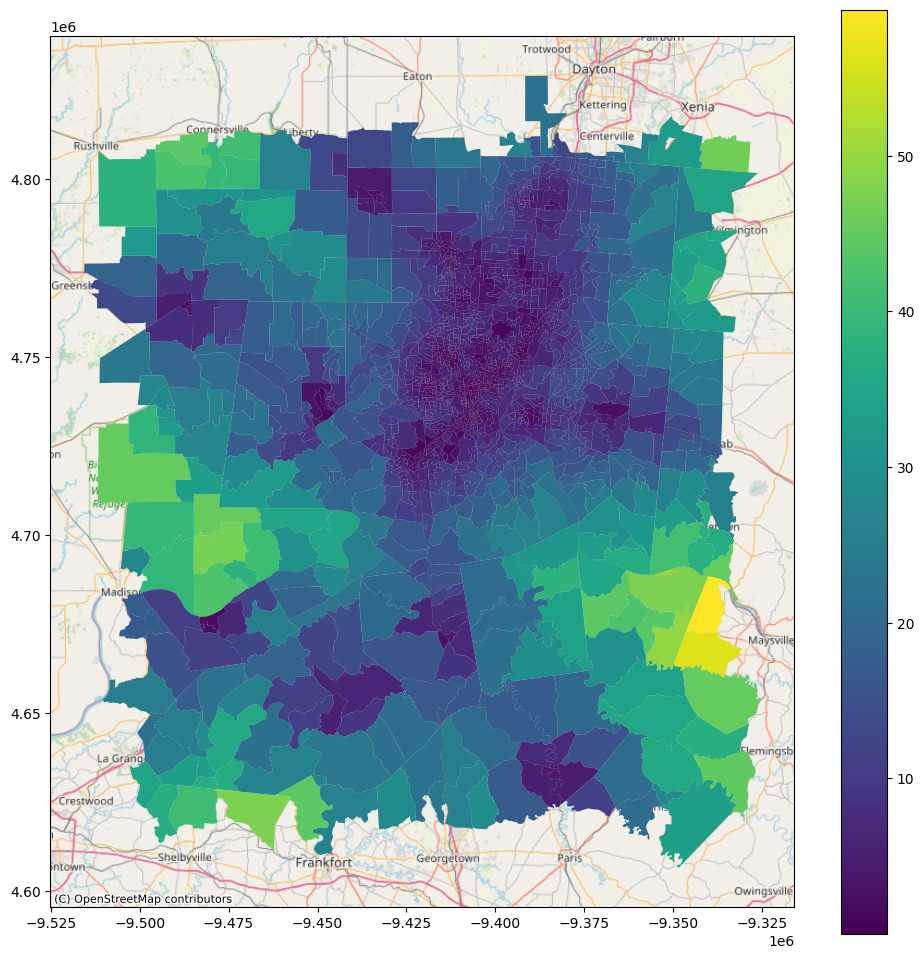

In [ ]:
ax = geom_result_osm.plot(column="time_BEDS", figsize=(12,12), legend=True)
cx.add_basemap(ax=ax, crs=geom_result_osm.crs, source=cx.providers.OpenStreetMap.Mapnik)

In [ ]:
pathlib.Path(result_dir).mkdir(parents=True, exist_ok=True)
geom_result_osm.to_file(os.path.join(result_dir, "AccessibilityOSM.gpkg"), driver="GPKG")

<hr />

## Accessibility Using ML

In [ ]:
# tcm_ct2ct_ml = pd.read_csv("../data/tcm/TCM-128k-CT.csv")
tcm_ct2ct_ml = pd.read_csv("../data/travel_times/TCM-CBToCB-ML.csv")
print(f"The travel-cost matrix has {len(tcm_ct2ct_ml)} rows.")
tcm_ct2ct_ml["origin"] = tcm_ct2ct_ml["origin"].astype(str)
tcm_ct2ct_ml["origin"] = tcm_ct2ct_ml["origin"].str.zfill(11)
tcm_ct2ct_ml["destination"] = tcm_ct2ct_ml["destination"].astype(str)
tcm_ct2ct_ml["destination"] = tcm_ct2ct_ml["destination"].str.zfill(11)
# convert from seconds to minutes
tcm_ct2ct_ml["minutes"] = tcm_ct2ct_ml["seconds"] / 60.0
tcm_ct2ct_ml.head()

The travel-cost matrix has 3045025 rows.


,origin,destination,seconds,minutes
0,181559657001,181559657001,0.0,0.000000
1,181559657001,180290806011,2269.6,37.826667
2,181559657001,181559658001,1811.8,30.196667
3,181559657001,181379686004,3456.7,57.611667
4,181559657001,181159657002,1241.0,20.683333


In [ ]:
# tcm_hos2ct_ml = pd.read_csv("../data/tcm/TCM-128k-Hos.csv")
tcm_hos2ct_ml = pd.read_csv("../data/travel_times/TCM-HosToCB-ML.csv")
print(f"The travel-cost matrix has {len(tcm_hos2ct_ml)} rows.")
tcm_hos2ct_ml["origin"] = tcm_hos2ct_ml["origin"].astype(str)
tcm_hos2ct_ml["origin"] = tcm_hos2ct_ml["origin"].str.zfill(10)
tcm_hos2ct_ml["destination"] = tcm_hos2ct_ml["destination"].astype(str)
tcm_hos2ct_ml["destination"] = tcm_hos2ct_ml["destination"].str.zfill(11)
# convert from seconds to minutes
tcm_hos2ct_ml["minutes"] = tcm_hos2ct_ml["seconds"] / 60.0
tcm_hos2ct_ml.head()

The travel-cost matrix has 101210 rows.


,origin,destination,seconds,minutes
0,0001947025,181559657001,2132.7,35.545000
1,0001947025,180290806011,977.2,16.286667
2,0001947025,181559658001,2870.5,47.841667
3,0001947025,181379686004,2291.6,38.193333
4,0001947025,181159657002,1063.3,17.721667


In [ ]:
access_ml = access.Access(demand_df  = pop,
                               demand_index = pop_id,
                               demand_value = pop_data,
                               supply_df    = hos,
                               supply_index = 'ID',
                               supply_value = 'BEDS',
                               cost_df      = tcm_hos2ct_ml,
                               cost_origin  = 'destination',  # this is origin ID
                               cost_dest    = 'origin',  # this is supply ID
                               cost_name    = "minutes",
                               neighbor_cost_df      = tcm_ct2ct_ml,
                               neighbor_cost_origin  = 'origin',
                               neighbor_cost_dest    = 'destination',
                               neighbor_cost_name    = "minutes")

Now, we calculate E2SFCA with the access package:

In [ ]:
access_ml.weighted_catchment(name="gravity", weight_fn=gravity)

,gravity_BEDS
GEOID,
180290801011,17098.087883
180290801012,17152.217323
180290801031,29928.731187
180290801032,29922.333445
180290801033,29486.669888
...,...
391650325011,30607.515512
391650325012,35127.463102
391650325021,37056.951493


In [ ]:
access_ml.fca_ratio(name="fca_30", max_cost=30)
access_ml.fca_ratio(name="fca_60", max_cost=60)

/data/keeling/a/michels9/anaconda3/envs/tcm/lib/python3.8/site-packages/access/fca.py:161: UserWarning: some tracts may be unaccounted for in supply_cost
  warnings.warn("some tracts may be unaccounted for in supply_cost", stacklevel=1)
/data/keeling/a/michels9/anaconda3/envs/tcm/lib/python3.8/site-packages/access/fca.py:161: UserWarning: some tracts may be unaccounted for in supply_cost
  warnings.warn("some tracts may be unaccounted for in supply_cost", stacklevel=1)


,fca_60_BEDS
GEOID,
180290801011,0.005043
180290801012,0.004717
180290801031,0.004228
180290801032,0.004236
180290801033,0.004257
...,...
391650325011,0.004413
391650325012,0.004381
391650325021,0.004341


In [ ]:
access_ml.two_stage_fca(name="2sfca_30", max_cost=30)
access_ml.two_stage_fca(name="2sfca_60", max_cost=60)

,2sfca_60_BEDS
GEOID,
180290801011,0.003925
180290801012,0.003758
180290801031,0.004026
180290801032,0.004026
180290801033,0.004026
...,...
391650325011,0.003994
391650325012,0.003994
391650325021,0.003994


In [ ]:
access_ml.enhanced_two_stage_fca(name="e2sfca_30", weight_fn=e2sfca_weights_30, max_cost=30)
access_ml.enhanced_two_stage_fca(name="e2sfca_60", weight_fn=e2sfca_weights_60, max_cost=60)

,e2sfca_60_BEDS
GEOID,
180290801011,0.001963
180290801012,0.001890
180290801031,0.003383
180290801032,0.003612
180290801033,0.003367
...,...
391650325011,0.002723
391650325012,0.002999
391650325021,0.003022


In [ ]:
access_ml.enhanced_two_stage_fca(name="g2sfca10", weight_fn=gaussian10)
access_ml.enhanced_two_stage_fca(name="g2sfca20", weight_fn=gaussian20)

,g2sfca20_BEDS
GEOID,
180290801011,0.001022
180290801012,0.001018
180290801031,0.002414
180290801032,0.002411
180290801033,0.002345
...,...
391650325011,0.001812
391650325012,0.002000
391650325021,0.002075


In [ ]:
access_ml.three_stage_fca(name="3sfca")

,3sfca_BEDS
GEOID,
180290801011,0.000629
180290801012,0.001545
180290801031,0.003048
180290801032,0.002832
180290801033,0.002869
...,...
391650325011,0.001969
391650325012,0.002580
391650325021,0.002580


In [ ]:
access_ml.raam(name="raam30", tau=30)

,raam30_BEDS
GEOID,
180290801011,2.027171
180290801012,2.171375
180290801031,1.759437
180290801032,1.716607
180290801033,1.863113
...,...
391650325011,1.938497
391650325012,1.889253
391650325021,1.885741


In [ ]:
# access_ml.raam(name="raam60", tau=60)

In [ ]:
nearest = time2nearest(pop, pop_id, hos, "ID", tcm_hos2ct_ml, "destination", "origin", "minutes")
nearest = nearest.rename(columns={"minutes": "time_BEDS"})
nearest.head()

,time_BEDS
GEOID,
180290801011,17.068333
180290801012,17.216667
180290801031,16.016667
180290801032,19.018333
180290801033,13.556667


In [ ]:
result_ml = access_ml.access_df.merge(nearest, left_index=True, right_index=True)
result_ml = result_ml.reset_index()
result_ml.head()

,GEOID,pop,gravity_BEDS,fca_30_BEDS,fca_60_BEDS,2sfca_30_BEDS,2sfca_60_BEDS,e2sfca_30_BEDS,e2sfca_60_BEDS,g2sfca10_BEDS,g2sfca20_BEDS,3sfca_BEDS,raam30_BEDS,time_BEDS
0,180290801011,1858.0,17098.087883,0.000317,0.005043,0.000342,0.003925,0.000554,0.001963,0.000417,0.001022,0.000629,2.027171,17.068333
1,180290801012,760.0,17152.217323,0.001187,0.004717,0.000224,0.003758,0.000515,0.001890,0.000525,0.001018,0.001545,2.171375,17.216667
2,180290801031,1755.0,29928.731187,0.004460,0.004228,0.001827,0.004026,0.001278,0.003383,0.000867,0.002414,0.003048,1.759437,16.016667
3,180290801032,1417.0,29922.333445,0.005604,0.004236,0.001915,0.004026,0.001263,0.003612,0.000605,0.002411,0.002832,1.716607,19.018333
4,180290801033,2272.0,29486.669888,0.004866,0.004257,0.001919,0.004026,0.001322,0.003367,0.001131,0.002345,0.002869,1.863113,13.556667


Just some quick data cleaning to:

* reset the index so that FIPS is a normal column
* cast the FIPS column to a string for easy joining
* replace any zeroes with nan to distinguish between low access and no access
* multiply our values by 1000 to get an easier to interpret "hospital beds per thousand people."

In [ ]:
supply_field = "BEDS"
result_cols = [
    "gravity", "fca_30", "fca_60",
    "2sfca_30", "2sfca_60", "e2sfca_30",
    "e2sfca_60", "g2sfca10", "g2sfca20",
    "3sfca", "raam30", "time"
]
result_cols = [x + f"_{supply_field}" for x in result_cols]
result_title_mapper = [
    "Gravity",
    "FCA 30 mins",
    "FCA 60 mins",
    "2SFCA 30 mins",
    "2SFCA 60 mins",
    "E2SFCA 30 mins",
    "E2SFCA 60 mins",
    "Gaussian 2SFCA 10",
    "Gaussian 2SFCA 20",
    "3SFCA",
    "RAAM 30",
    "Time"
]

In [ ]:
result_ml[pop_id] = result_ml[pop_id].astype(str)
# replace zeroes with nan to help distinguish between low and no access
for result_col in result_cols:
    result_ml[result_col] = result_ml[result_col].replace(0, np.nan)
    if "fca" in result_col:
        result_ml[result_col] = result_ml[result_col] * 1000
result_ml.head()

,GEOID,pop,gravity_BEDS,fca_30_BEDS,fca_60_BEDS,2sfca_30_BEDS,2sfca_60_BEDS,e2sfca_30_BEDS,e2sfca_60_BEDS,g2sfca10_BEDS,g2sfca20_BEDS,3sfca_BEDS,raam30_BEDS,time_BEDS
0,180290801011,1858.0,17098.087883,0.316668,5.042767,0.341670,3.925026,0.554084,1.963486,0.417135,1.022220,0.629298,2.027171,17.068333
1,180290801012,760.0,17152.217323,1.186873,4.716922,0.224372,3.758012,0.515104,1.889691,0.524729,1.018105,1.545058,2.171375,17.216667
2,180290801031,1755.0,29928.731187,4.459899,4.227984,1.827407,4.026345,1.278176,3.382638,0.866872,2.413774,3.048005,1.759437,16.016667
3,180290801032,1417.0,29922.333445,5.604148,4.235697,1.914738,4.026345,1.263290,3.612230,0.605350,2.410787,2.832194,1.716607,19.018333
4,180290801033,2272.0,29486.669888,4.865941,4.257488,1.918601,4.026345,1.321801,3.367285,1.131150,2.344881,2.869209,1.863113,13.556667


Next, we join our result  to the population geometry to make it a GeoDataFrame and plot:

In [ ]:
result_ml = result_ml.drop(columns=["pop"])
geom_result_ml = gpd.GeoDataFrame(pop.merge(result_ml, on=pop_id))
geom_result_ml = geom_result_ml.set_crs(pop.crs)
geom_result_ml.head()

,GEOID,pop,geometry,gravity_BEDS,fca_30_BEDS,fca_60_BEDS,2sfca_30_BEDS,2sfca_60_BEDS,e2sfca_30_BEDS,e2sfca_60_BEDS,g2sfca10_BEDS,g2sfca20_BEDS,3sfca_BEDS,raam30_BEDS,time_BEDS
0,181559657001,1436.0,"POLYGON ((-9452364.248 4699670.024, -9452185.0...",7731.493112,NaN,4.020467,NaN,0.959672,NaN,0.495719,0.007090,0.237309,0.359669,2.822518,35.545000
1,180290806011,754.0,"POLYGON ((-9467166.841 4724498.747, -9467157.2...",16008.988373,1.207492,4.784193,0.224372,3.689832,0.515104,1.773964,0.602935,0.857525,1.599397,2.172270,16.286667
2,181559658001,1083.0,"POLYGON ((-9484772.912 4709332.118, -9484737.6...",5388.186537,NaN,1.107354,NaN,0.108129,NaN,0.069186,0.000026,0.041260,0.143686,3.221799,47.841667
3,181379686004,926.0,"POLYGON ((-9497442.584 4736558.444, -9497293.8...",7112.139520,0.708215,1.356801,0.341670,0.196486,0.179263,0.161062,0.043622,0.148978,0.662588,2.919486,27.090000
4,181159657002,970.0,"POLYGON ((-9449366.163 4719337.684, -9448996.9...",14936.064383,1.739130,5.073134,0.224372,3.742995,0.515104,1.423326,0.470750,0.747198,1.580374,2.216450,17.721667


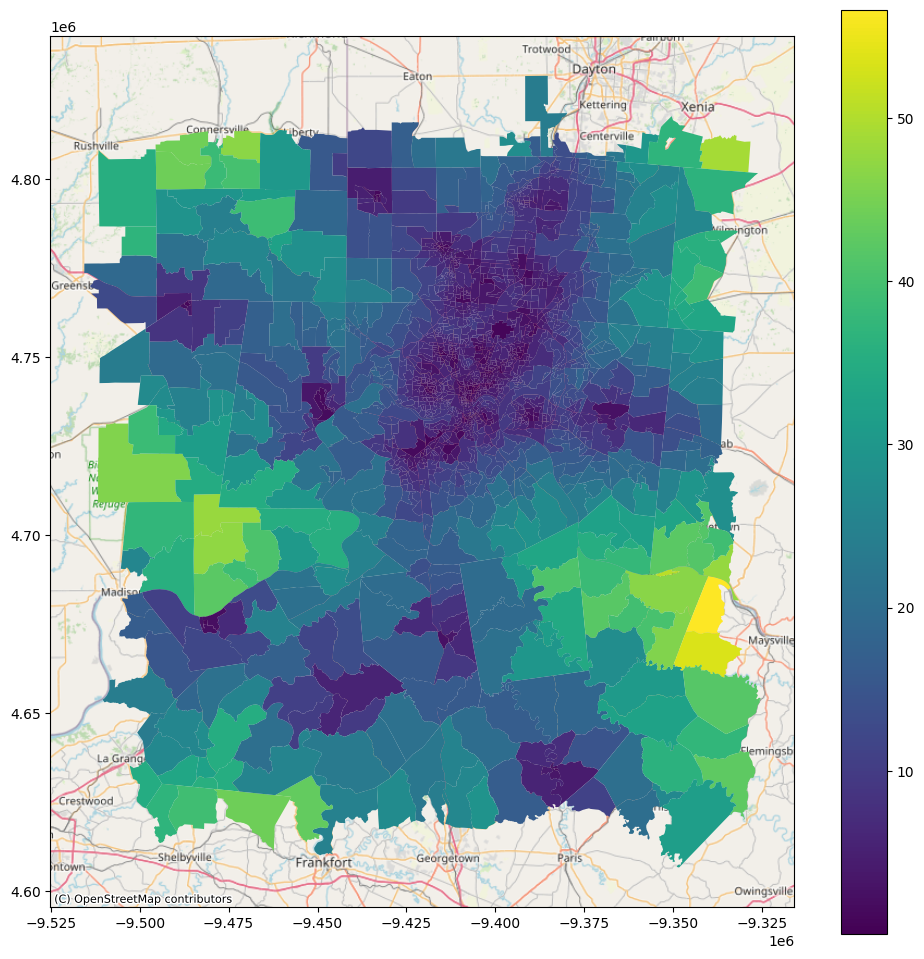

In [ ]:
ax = geom_result_ml.plot(column="time_BEDS", figsize=(12,12), legend=True)
cx.add_basemap(ax=ax, crs=geom_result_ml.crs, source=cx.providers.OpenStreetMap.Mapnik)

In [ ]:
pathlib.Path(result_dir).mkdir(parents=True, exist_ok=True)
geom_result_ml.to_file(os.path.join(result_dir, "AccessibilityML.gpkg"), driver="GPKG")

## Calculating the Differences

In [ ]:
difference = geom_result_osm.copy(deep=True)
for i, result_col in enumerate(result_cols):
    difference.rename(columns={result_col : str("osm_" + result_col)}, inplace=True)
    difference[f"ml_{result_col}"] = geom_result_ml[result_col]
    difference[f"diff_{result_col}"] = geom_result_osm[result_col] - geom_result_ml[result_col]
difference.head()

,GEOID,pop,geometry,osm_gravity_BEDS,osm_fca_30_BEDS,osm_fca_60_BEDS,osm_2sfca_30_BEDS,osm_2sfca_60_BEDS,osm_e2sfca_30_BEDS,osm_e2sfca_60_BEDS,...,ml_g2sfca10_BEDS,diff_g2sfca10_BEDS,ml_g2sfca20_BEDS,diff_g2sfca20_BEDS,ml_3sfca_BEDS,diff_3sfca_BEDS,ml_raam30_BEDS,diff_raam30_BEDS,ml_time_BEDS,diff_time_BEDS
0,181559657001,1436.0,"POLYGON ((-9452364.248 4699670.024, -9452185.0...",7978.499281,NaN,3.767271,NaN,0.961764,NaN,0.465217,...,0.007090,-0.000696,0.237309,-0.024270,0.359669,-0.032987,2.822518,-0.018949,35.545000,-0.528333
1,180290806011,754.0,"POLYGON ((-9467166.841 4724498.747, -9467157.2...",18365.602374,1.029813,4.495023,0.173069,3.708168,0.414122,1.813077,...,0.602935,0.110063,0.857525,0.153844,1.599397,-0.119089,2.172270,-0.065685,16.286667,-2.163333
2,181559658001,1083.0,"POLYGON ((-9484772.912 4709332.118, -9484737.6...",5826.161203,NaN,1.087511,NaN,0.096503,NaN,0.060476,...,0.000026,0.000039,0.041260,0.003919,0.143686,0.000493,3.221799,-0.071523,47.841667,-2.415000
3,181379686004,926.0,"POLYGON ((-9497442.584 4736558.444, -9497293.8...",7729.521595,0.735424,4.742329,0.370030,0.811998,0.185795,0.336383,...,0.043622,-0.005807,0.148978,0.008061,0.662588,0.035205,2.919486,-0.075646,27.090000,0.675000
4,181159657002,970.0,"POLYGON ((-9449366.163 4719337.684, -9448996.9...",15727.096438,1.648975,4.855401,0.173069,3.718422,0.414122,1.535537,...,0.470750,-0.029399,0.747198,0.010178,1.580374,-0.083426,2.216450,-0.009387,17.721667,-0.583333


In [ ]:
for i, result_col in enumerate(result_cols):
    sums = difference[f"osm_{result_col}"] + difference[f"ml_{result_col}"]
    difference[f"pdiff_{result_col}"] = 100 * difference[f"diff_{result_col}"] / (sums / 2)
difference.head()

,GEOID,pop,geometry,osm_gravity_BEDS,osm_fca_30_BEDS,osm_fca_60_BEDS,osm_2sfca_30_BEDS,osm_2sfca_60_BEDS,osm_e2sfca_30_BEDS,osm_e2sfca_60_BEDS,...,pdiff_fca_60_BEDS,pdiff_2sfca_30_BEDS,pdiff_2sfca_60_BEDS,pdiff_e2sfca_30_BEDS,pdiff_e2sfca_60_BEDS,pdiff_g2sfca10_BEDS,pdiff_g2sfca20_BEDS,pdiff_3sfca_BEDS,pdiff_raam30_BEDS,pdiff_time_BEDS
0,181559657001,1436.0,"POLYGON ((-9452364.248 4699670.024, -9452185.0...",7978.499281,NaN,3.767271,NaN,0.961764,NaN,0.465217,...,-6.502440,NaN,0.217749,NaN,-6.348386,-10.317679,-10.778322,-9.612330,-0.673620,-1.497508
1,180290806011,754.0,"POLYGON ((-9467166.841 4724498.747, -9467157.2...",18365.602374,1.029813,4.495023,0.173069,3.708168,0.414122,1.813077,...,-6.232647,-25.816882,0.495696,-21.734627,2.180788,16.727803,16.463658,-7.733806,-3.070217,-14.227776
2,181559658001,1083.0,"POLYGON ((-9484772.912 4709332.118, -9484737.6...",5826.161203,NaN,1.087511,NaN,0.096503,NaN,0.060476,...,-1.808083,NaN,-11.363506,NaN,-13.434405,86.214700,9.067486,0.342296,-2.244886,-5.178607
3,181379686004,926.0,"POLYGON ((-9497442.584 4736558.444, -9497293.8...",7729.521595,0.735424,4.742329,0.370030,0.811998,0.185795,0.336383,...,111.016731,7.969758,122.066619,3.578873,70.488624,-14.261745,5.268497,5.175760,-2.625088,2.461034
4,181159657002,970.0,"POLYGON ((-9449366.163 4719337.684, -9448996.9...",15727.096438,1.648975,4.855401,0.173069,3.718422,0.414122,1.535537,...,-4.386004,-25.816882,-0.658646,-21.734627,7.584681,-6.446460,1.352952,-5.421968,-0.424392,-3.346720


In [ ]:
difference.to_file(os.path.join(result_dir, "AccessibilityDiff.gpkg"), driver="GPKG")

In [ ]:
len(result_cols)

12